# AI Weather Prediction Project Notebook

#### Order
1. Decision Tree Regressor
2. XGBoost Classification: Precipitation Percentage
3. XGBoost Classification: Precipitation Category
4. TensorFlow Neuro Network

#### Load Libraries to be used by all models. 

In [1155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost

from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

from joblib import dump, load

plt.rcParams['figure.figsize']=(6,4)

In [1156]:
!pip install openpyxl


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1157]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Decision Tree Regressor

In [1158]:
weather_data = pd.read_csv('weather_data_excel.csv')
print(weather_data.columns)


Index(['Location', 'Date_Time', 'Temperature_C', 'Humidity_pct',
       'Precipitation_mm', 'Wind_Speed_kmh', 'Temperature_F', 'Date',
       'Military_Time', 'Rain_Category', 'Rain_Cat_Num', 'Precipitation_in'],
      dtype='object')


In [1159]:
y = weather_data['Precipitation_mm']
X = weather_data.drop(columns=['Precipitation_mm', 'Rain_Category', 'Location', 'Date', 'Military_Time',  'Precipitation_in', 'Temperature_C', 'Rain_Cat_Num', 'Date_Time'])

In [1160]:
X.columns

Index(['Humidity_pct', 'Wind_Speed_kmh', 'Temperature_F'], dtype='object')

In [1161]:
y.describe()

count    1000000.000000
mean           5.109639
std            2.947997
min            0.000009
25%            2.580694
50%            5.109917
75%            7.613750
max           14.971583
Name: Precipitation_mm, dtype: float64

In [1162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [1163]:
print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ', y_test.shape)

X_train.shape =  (800000, 3)
y_train.shape =  (800000,)
X_test.shape =  (200000, 3)
y_test.shape =  (200000,)


In [1164]:
dt = DecisionTreeRegressor(max_depth=10)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10)

In [1165]:
y_train_pred = dt.predict(X_train)
print(r2_score(y_train, y_train_pred))
y_test_pred = dt.predict(X_test)
print(r2_score(y_test, y_test_pred))

0.0040186065814881156
0.001484296522613393


In [1166]:
y_train_pred

array([5.11409281, 5.11409281, 5.11409281, ..., 5.11409281, 5.11409281,
       5.11409281])

In [1167]:
y_test_pred

array([5.11409281, 5.09338794, 5.11409281, ..., 5.11409281, 5.11409281,
       5.11409281])

In [1168]:
training_r2 = []
testing_r2 = []

In [1169]:
for depth in range(1, 5):
    dtr = DecisionTreeRegressor( max_depth = depth )
    dtr.fit(X_train, y_train)
    
    y_train_pred = dtr.predict(X_train)
    
    # Training R2 Score
    training_r2.append(r2_score(y_train, y_train_pred))

    y_test_pred = dtr.predict(X_test)

    # Testing R2 Score
    testing_r2.append(r2_score(y_test, y_test_pred))    
    

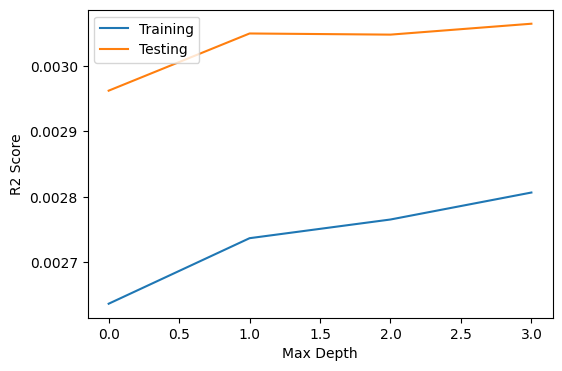

In [1170]:
plt.plot(training_r2, label="Training")
plt.plot(testing_r2, label = "Testing")
plt.xlabel('Max Depth')
plt.ylabel('R2 Score')
plt.legend(loc = 'upper left')
plt.show()

## XGBoost Regressor 

In [1171]:
df = pd.read_csv('weather_data_excel.csv')

In [1172]:
df['Date'] = pd.to_datetime(df['Date'])

In [1173]:
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Year'] = df['Date'].dt.year

In [1174]:
location_encoder = LabelEncoder()
df['Location_encoded'] = location_encoder.fit_transform(df['Location'])

In [1175]:
# Establish X and y
y = df['Precipitation_mm']
X = df.drop(columns=['Precipitation_mm','Military_Time','Rain_Category', 'Location', 'Date', 'Precipitation_in', 'Temperature_C', 'Rain_Cat_Num', 'Date_Time'])

In [1176]:
# Check if the correct columns for X have been added
X.columns

Index(['Humidity_pct', 'Wind_Speed_kmh', 'Temperature_F', 'Month', 'Day',
       'Year', 'Location_encoded'],
      dtype='object')

In [1177]:
# Prepare Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4700)

In [1178]:
# Create XGBoost Regression Model

xgb_r = xgboost.XGBRegressor(objective='reg:squarederror', enable_categorical=True, n_estimators = 10 )

In [1179]:
# Fit the model
xgb_r.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [1180]:
# Determine Training R2 Score
prediction = xgb_r.predict(X_train)
training_r2 = r2_score(y_train, prediction )
training_r2

0.031871178280234336

In [1181]:
# Determine Testing R2 Score
prediction = xgb_r.predict(X_test)
testing_r2 = r2_score(y_test, prediction )
testing_r2

0.028456828603069195

### Test XGBoost Regressor at depths 1 through 10

In [1182]:
training_r2 = []
testing_r2 = []

In [1183]:
for trees in range(1, 30):
    xgb_r = xgboost.XGBRegressor(objective='reg:squarederror', enable_categorical=True, n_estimators = trees)
    xgb_r.fit(X_train, y_train)
    
    y_train_pred = xgb_r.predict(X_train)
    training_r2.append(r2_score(y_train, y_train_pred))
    
    y_test_pred = xgb_r.predict(X_test)
    testing_r2.append(r2_score(y_test, y_test_pred))
    

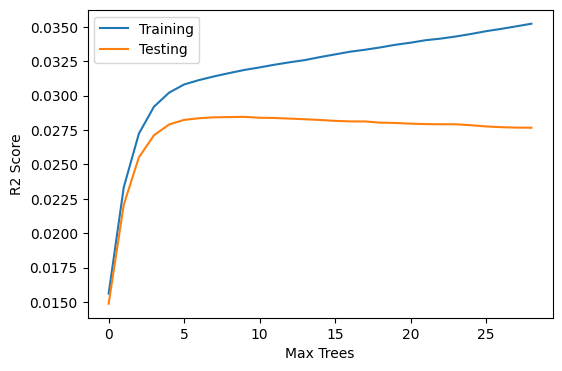

In [1184]:
plt.plot(training_r2, label="Training")
plt.plot(testing_r2, label = "Testing")
plt.xlabel('Max Trees')
plt.ylabel('R2 Score')
plt.legend(loc = 'upper left')
plt.show()

## XGBoost Classifier: Percentage Rainfall


In [1185]:
data_frame = pd.read_csv('weather_data_excel.csv')

In [1186]:
data_frame['Date'] = pd.to_datetime(data_frame['Date'])

In [1187]:
data_frame['Month'] = data_frame['Date'].dt.month
data_frame['Day'] = data_frame['Date'].dt.day


In [1188]:
location_encoder = LabelEncoder()

In [1189]:
data_frame['Location_encoded'] = location_encoder.fit_transform(data_frame['Location'])

In [1190]:
# This is the threshold, in mm, for if rainfall is classified as rain or not
# 0.254mm is the threshold the National Weather Service uses when determine if precipitation should be reported as rain
threshold = 0.254
data_frame['Rainfall'] = (data_frame['Precipitation_mm'] >= threshold).astype(int)

In [1191]:
data_frame_pos = data_frame[data_frame['Rainfall']==1]
data_frame_neg = data_frame[data_frame['Rainfall']==0]

num = data_frame.shape[0]
num_pos = data_frame_pos.shape[0]
num_neg = data_frame_neg.shape[0]

print('Number of examples = ', num)
print('Number of positive examples = ', num_pos)
print('Number of negative examples = ', num_neg)
print(f'Percentage of positive examples = {np.round((num_pos / num) * 100, 4)}%')


Number of examples =  1000000
Number of positive examples =  975735
Number of negative examples =  24265
Percentage of positive examples = 97.5735%


In [1192]:
data_frame.sample(5)

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Temperature_F,Date,Military_Time,Rain_Category,Rain_Cat_Num,Precipitation_in,Month,Day,Location_encoded,Rainfall
263884,Dallas,1/12/2024 4:38,20.871960,60.096763,2.721884,16.278444,69.569527,2024-01-12,04:38,Moderate Rain,1,0.107161,1,12,1,1
496830,New York,4/25/2024 13:49,10.097554,81.460673,5.078481,25.538364,50.175597,2024-04-25,13:49,Moderate Rain,1,0.199940,4,25,4,1
966320,Los Angeles,3/9/2024 21:32,31.538526,74.372609,9.774371,24.292020,88.769348,2024-03-09,21:32,Heavy Rain,2,0.384818,3,9,3,1
815978,San Diego,5/16/2024 14:01,30.548757,54.640539,8.268420,24.222429,86.987762,2024-05-16,14:01,Heavy Rain,2,0.325528,5,16,8,1
592848,Los Angeles,2/11/2024 3:31,38.752371,65.764331,6.038251,23.979952,101.754268,2024-02-11,03:31,Moderate Rain,1,0.237726,2,11,3,1


In [1193]:
y=data_frame['Rainfall']

In [1194]:
X = data_frame.drop(columns=['Precipitation_in', 'Precipitation_mm', 'Date', 'Military_Time', 'Rain_Category', 'Rain_Cat_Num', 'Location', 'Rainfall', 'Date_Time', 'Temperature_C'])

In [1195]:
X.columns

Index(['Humidity_pct', 'Wind_Speed_kmh', 'Temperature_F', 'Month', 'Day',
       'Location_encoded'],
      dtype='object')

In [1196]:
X.sample(5)

,Humidity_pct,Wind_Speed_kmh,Temperature_F,Month,Day,Location_encoded
459029,79.197858,17.958097,83.067873,5,5,3
387113,67.354889,5.122129,71.708605,4,19,1
262154,55.018727,24.945753,41.918520,2,29,2
836802,82.469921,20.570571,69.920429,5,4,8
534339,44.123165,19.023696,19.637217,4,27,6


In [1197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4700)

In [1198]:
xgb_c = xgboost.XGBClassifier( n_estimators = 100, max_depth = 10 )

In [1199]:
xgb_c.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [1200]:
y_train_pred = xgb_c.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
training_accuracy

0.976185

In [1201]:
y_test_pred = xgb_c.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_test_pred)
testing_accuracy


0.975895

In [1202]:
# Saving the model and encoder
#dump(xgb_c, 'rain_probability_predictor.pkl')
#dump(location_encoder, 'location_encoder.pkl')

### See how important each input is 

In [1203]:
X.columns

Index(['Humidity_pct', 'Wind_Speed_kmh', 'Temperature_F', 'Month', 'Day',
       'Location_encoded'],
      dtype='object')

In [1204]:
xgb_c.feature_importances_

array([0.16067868, 0.1614316 , 0.1611361 , 0.17257822, 0.15485017,
       0.18932527], dtype=float32)

### Visualise Data

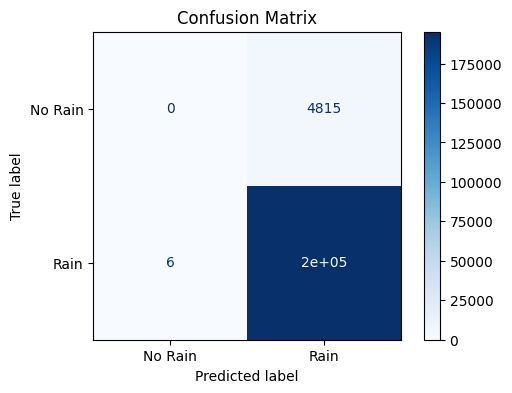

In [1205]:
y_pred = xgb_c.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=['No Rain', 'Rain'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## XGBoost Classifier

In [1206]:
# Write XGB Classifier Code Here
# edf = pd.read_excel('weather_data_excel.xlsx')
edf = pd.read_csv('weather_data_excel.csv')
edf = edf.iloc[:1000000]
edf

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Temperature_F,Date,Military_Time,Rain_Category,Rain_Cat_Num,Precipitation_in
0,San Jose,4/16/2024 3:44,17.199707,71.429300,0.000009,4.665638,62.959473,4/16/2024,03:44,Light Rain,0,3.505573e-07
1,Houston,3/21/2024 15:32,2.238515,51.415780,0.000010,3.578842,36.029327,3/21/2024,15:32,Light Rain,0,4.092205e-07
2,Houston,2/27/2024 1:05,29.209095,50.340174,0.000029,9.968438,84.576371,2/27/2024,01:05,Light Rain,0,1.157432e-06
3,Phoenix,4/23/2024 0:39,15.041607,78.159361,0.000032,21.713389,59.074893,4/23/2024,00:39,Light Rain,0,1.261625e-06
4,San Diego,5/2/2024 20:45,12.799834,62.244326,0.000089,27.277552,55.039702,5/2/2024,20:45,Light Rain,0,3.493707e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,Phoenix,2/22/2024 8:35,-0.872399,37.180646,14.896195,18.147337,30.429682,2/22/2024,08:35,Heavy Rain,2,5.864644e-01
999996,Phoenix,1/10/2024 19:03,14.200155,78.319692,14.912323,19.157155,57.560279,1/10/2024,19:03,Heavy Rain,2,5.870993e-01
999997,Phoenix,1/8/2024 21:01,19.848658,75.733769,14.917006,15.453639,67.727585,1/8/2024,21:01,Heavy Rain,2,5.872837e-01
999998,Phoenix,1/16/2024 8:12,-3.586550,81.166402,14.926332,13.758749,25.544210,1/16/2024,08:12,Heavy Rain,2,5.876509e-01


In [1207]:
edf['Hour'] = edf['Military_Time'].apply(lambda x: int(x.split(":")[0]))
edf['Minute'] = edf['Military_Time'].apply(lambda x: int(x.split(":")[1]))
edf

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Temperature_F,Date,Military_Time,Rain_Category,Rain_Cat_Num,Precipitation_in,Hour,Minute
0,San Jose,4/16/2024 3:44,17.199707,71.429300,0.000009,4.665638,62.959473,4/16/2024,03:44,Light Rain,0,3.505573e-07,3,44
1,Houston,3/21/2024 15:32,2.238515,51.415780,0.000010,3.578842,36.029327,3/21/2024,15:32,Light Rain,0,4.092205e-07,15,32
2,Houston,2/27/2024 1:05,29.209095,50.340174,0.000029,9.968438,84.576371,2/27/2024,01:05,Light Rain,0,1.157432e-06,1,5
3,Phoenix,4/23/2024 0:39,15.041607,78.159361,0.000032,21.713389,59.074893,4/23/2024,00:39,Light Rain,0,1.261625e-06,0,39
4,San Diego,5/2/2024 20:45,12.799834,62.244326,0.000089,27.277552,55.039702,5/2/2024,20:45,Light Rain,0,3.493707e-06,20,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,Phoenix,2/22/2024 8:35,-0.872399,37.180646,14.896195,18.147337,30.429682,2/22/2024,08:35,Heavy Rain,2,5.864644e-01,8,35
999996,Phoenix,1/10/2024 19:03,14.200155,78.319692,14.912323,19.157155,57.560279,1/10/2024,19:03,Heavy Rain,2,5.870993e-01,19,3
999997,Phoenix,1/8/2024 21:01,19.848658,75.733769,14.917006,15.453639,67.727585,1/8/2024,21:01,Heavy Rain,2,5.872837e-01,21,1
999998,Phoenix,1/16/2024 8:12,-3.586550,81.166402,14.926332,13.758749,25.544210,1/16/2024,08:12,Heavy Rain,2,5.876509e-01,8,12


In [1208]:
#Removing empety rows
X = edf.drop(columns=["Date", "Location", "Rain_Cat_Num", "Rain_Category", 'Military_Time','Date_Time', 'Precipitation_in'])
X

,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Temperature_F,Hour,Minute
0,17.199707,71.429300,0.000009,4.665638,62.959473,3,44
1,2.238515,51.415780,0.000010,3.578842,36.029327,15,32
2,29.209095,50.340174,0.000029,9.968438,84.576371,1,5
3,15.041607,78.159361,0.000032,21.713389,59.074893,0,39
4,12.799834,62.244326,0.000089,27.277552,55.039702,20,45
...,...,...,...,...,...,...,...
999995,-0.872399,37.180646,14.896195,18.147337,30.429682,8,35
999996,14.200155,78.319692,14.912323,19.157155,57.560279,19,3
999997,19.848658,75.733769,14.917006,15.453639,67.727585,21,1
999998,-3.586550,81.166402,14.926332,13.758749,25.544210,8,12


In [1209]:
y = edf["Rain_Cat_Num"]
y

0         0
1         0
2         0
3         0
4         0
         ..
999995    2
999996    2
999997    2
999998    2
999999    2
Name: Rain_Cat_Num, Length: 1000000, dtype: int64

In [1210]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y)

In [1211]:
y_train

996170    2
886508    2
689586    1
76836     0
123665    0
         ..
646585    1
733649    1
525212    1
631782    1
436719    1
Name: Rain_Cat_Num, Length: 700000, dtype: int64

In [1212]:
y_test

602037    1
178625    0
874107    2
631077    1
858821    2
         ..
691720    1
419799    1
584437    1
980404    2
959033    2
Name: Rain_Cat_Num, Length: 300000, dtype: int64

In [1213]:
from xgboost import XGBClassifier

In [1214]:
xgb_clf = XGBClassifier(n_estimators=25, max_depth=25)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=25, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [1215]:
from sklearn.metrics import accuracy_score

In [1216]:
y_train_pred = xgb_clf.predict(X_train)

In [1217]:
accuracy_score(y_train, y_train_pred)

1.0

In [1218]:
y_test_pred = xgb_clf.predict(X_test)

In [1219]:
accuracy_score(y_test, y_test_pred)

0.9988833333333333

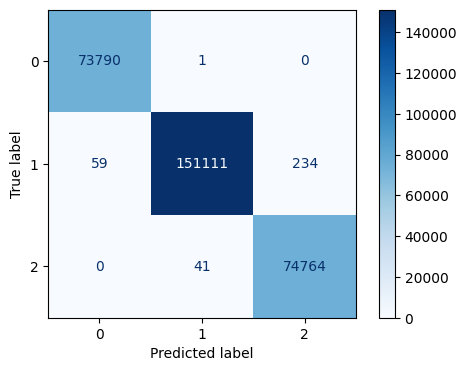

In [1220]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)


In [1221]:
X.columns

Index(['Temperature_C', 'Humidity_pct', 'Precipitation_mm', 'Wind_Speed_kmh',
       'Temperature_F', 'Hour', 'Minute'],
      dtype='object')

In [1222]:
xgb_clf.feature_importances_

array([2.8245646e-05, 2.8829092e-05, 9.9986035e-01, 2.8440296e-05,
       0.0000000e+00, 2.6302918e-05, 2.7945369e-05], dtype=float32)

In [1223]:
# r2Train = []
# r2Test = []
# for i in range(1, 31):
#     xgb = XGBClassifier(n_estimators=25, max_depth=1)
#     xgb.fit(X_train, y_train)
#     y_train_pred = dt.predict(X_train)
#     r2Train.append(r2_score(y_train, y_train_pred))
#     y_test_pred = dt.predict(X_test)
#     r2Test.append(r2_score(y_test, y_test_pred))

## Tensor Flow Neuro Network

In [1224]:
# Write Tensor Flow Neuro Network Code Here

In [1225]:
print("hello")

hello
